In [47]:
#Important packages needed to run the code
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import itertools
from scipy.interpolate import interp1d

In [48]:
filepath = 'Folder/'
filepath2 = 'digitalised_cutting_sheets/'

In [49]:
def slope(x1, x2, y1, y2):
    '''''function finds slope of x-points: x1and x2, and y-points: y1 and y2'''''
    m = (y2 - y1) / (x2 - x1)
    return m

In [50]:
def find_slope(array,i,n):
    #finds slope of the i´th point wrt i - 1, iteratively backwards n times
    #returns True, if all slopes are negative
    #returns False otherwise
    passed = True
    for j in range(n):
        if array[i - j] > array[i - j - 1]:
            passed = False
            break
    return passed

In [51]:
def set_encoder_values_to_depth(bagnumber, filename, plot = False): 
    '''''loads datasets and 
    returns the depth of the ice in an array.
    This is mainly done by working on the encoder 
    data. '''''
   

    ##################################################################################################################################
    #Loading Data arrays from filenames:
    
    if filename == '3157': #This file can't be loaded unless you skip the first nine rows
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 11)
        Mq_smpl = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 19)
        new_bag = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 20)
        breaks = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 21)
        Enc = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 7)
        Acq_Time = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 3)
        Acq_Time -= 5
    elif filename == '3350': #This file can't be loaded unless you skip the first five rows
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 11)
        Mq_smpl = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 19)
        new_bag = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 20)
        breaks = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 21)
        Enc = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 7)
        Acq_Time = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 3)
        Acq_Time -= 1
    else: #All other files start from the fourth row
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 11)
        Mq_smpl = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 19)
        new_bag = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 20)
        breaks = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 21)
        Enc = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 7)
        Acq_Time = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 3)
    
    #In this file all encoder values need to be set up. The two negatives in the '-=' and in the np.min(Enc) give a positive. They all need to be positive and reach zero:
    #They need to be set up so that the code works properly for them, as it only works for files where all encoder values are zero or larger.
    if filename == '3147':
        Enc -= np.min(Enc)

    if plot == True:
        plt.figure(figsize=(20,10))
        plt.plot(Acq_Time, Dust, 'y')
        enhanced_Mq_smpl = np.where(Mq_smpl == 0, Mq_smpl, 3000 * Mq_smpl)
        plt.plot(Acq_Time, enhanced_Mq_smpl, 'k')
        enhanced_new_bag = np.where(new_bag == 0, new_bag, 3000 * new_bag)
        plt.plot(Acq_Time, enhanced_new_bag, 'go')
        enhanced_breaks = np.where(breaks == 0, breaks, 3000 * breaks)
        plt.plot(Acq_Time, enhanced_breaks, 'ro')
        plt.xlabel('Acquisation Time [s]', fontsize=18)
        plt.ylabel('Dust counts [#]', fontsize=18)

        plt.figure(figsize=(20,10))
        plt.plot(Acq_Time, Enc, 'grey')
        enhanced_Mq_smpl = np.where(Mq_smpl == 0, Mq_smpl, 5000 * Mq_smpl)
        plt.plot(Acq_Time, enhanced_Mq_smpl, 'k')
        enhanced_new_bag = np.where(new_bag == 0, new_bag, 5000 * new_bag)
        plt.plot(Acq_Time, enhanced_new_bag, 'go')
        enhanced_breaks = np.where(breaks == 0, breaks, 5000 * breaks)
        plt.plot(Acq_Time, enhanced_breaks, 'ro')
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Encoder count', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder1.png')
        
    #In files 3157 and 3147 some encoder lines are ignored. Due to this the index of Mq_smpl has to be changed,
    #for the code to work the way I want it.
    if filename == '3157' or filename == '3147':
        for i in range(len(new_bag)):
            if new_bag[i] == 0 and new_bag[i + 1] == 1:
                index = i + 1
                break
        Mq_smpl[0:index] = 0
        
    #The same from above counts for here.    
    if filename == '3157' or filename == '3164':
        for i in reversed(range(len(new_bag))):
            if new_bag[i] == 1:
                index = i
                break
        Mq_smpl[index:] = 0
        
        
    ##################################################################################################################################    
        
            
    #Highest points of each encoder line is found, where the encoder is refitted after the ice is stacked.
    #This is done for the deletion of unwanted encoder points.
    highest_points_indices = []
  
    for i in range(len(Enc) - 1):
        if slope(Acq_Time[i], Acq_Time[i + 1], Enc[i], Enc[i + 1]) < -15 and slope(Acq_Time[i], Acq_Time[i + 1], Enc[i], Enc[i + 1]) > -25:
            highest_points_indices.append(int(Acq_Time[i]))
    
    #In this file a wrong highest_points_index is found
    if filename == '3506':
        for i in range(len(highest_points_indices)):
            if Enc[highest_points_indices[i - 1]] - Enc[highest_points_indices[i]] > 2000:
                highest_points_indices = np.delete(highest_points_indices, i - 1)
                break
    
    #The same counts as from above:
    if filename == '3402':
        for i in range(len(highest_points_indices)):
            if Enc[highest_points_indices[i - 1]] - Enc[highest_points_indices[i]] > 500:
                highest_points_indices = np.delete(highest_points_indices, [i - 1, i - 2])
                break
    
    exact_highest_points_indices = []
    
    for i,h in enumerate(highest_points_indices):
        if Mq_smpl[h] == 1 and Enc[h] - Enc[highest_points_indices[i - 1]] > 0: #If the first point is higher than the point before, the next point should be taken!
            exact_highest_points_indices.append(h)
    
    #In this file the last exact_highest_points is added (Here, the encoder broke off at the very last point)
    if filename == '3343':
        for i in range(exact_highest_points_indices[-1], len(Enc)):
            if Enc[i] > Enc[exact_highest_points_indices[-1]]:
                exact_highest_points_indices.append(i)
                break
     
    for i in range(len(Mq_smpl)):
        if Mq_smpl[i - 1] == 0 and Mq_smpl[i] == 1:
            exact_highest_points_indices.append(i)

    exact_highest_points_indices = sorted(exact_highest_points_indices)  
    
    #In each file, too many highest points are present:
    if filename == '3506':
        exact_highest_points_indices = np.delete(exact_highest_points_indices, 3)
    if filename == '3491':
        exact_highest_points_indices = np.delete(exact_highest_points_indices, -1)
    if filename == '3460':
        exact_highest_points_indices = np.delete(exact_highest_points_indices, [-1, -2])
    if filename == '3448':
        exact_highest_points_indices = np.delete(exact_highest_points_indices, [1, -1, -3])
    if filename == '3416':
        exact_highest_points_indices = np.delete(exact_highest_points_indices, 5)
    if filename == '3379':
        exact_highest_points_indices = np.delete(exact_highest_points_indices, -7)
    if filename == '3274':
        exact_highest_points_indices = np.delete(exact_highest_points_indices, -2)
    if filename == '3164':
        exact_highest_points_indices = np.delete(exact_highest_points_indices, -2)
    if filename == '3147':
        exact_highest_points_indices = np.delete(exact_highest_points_indices, [-1, -2, -3])
     
    if plot == True:
        plt.figure(figsize=(20,10))
        plt.plot(Acq_Time, Enc, 'grey')
        plt.plot(exact_highest_points_indices, Enc[exact_highest_points_indices], 'bo')
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Encoder count', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder2.png')

        
    ################################################################################################################################################      
        
                
    #Points of change of slope are found (where the encoder is taken down, in order to stack)
    points_of_slope_change = []
    for i in range(len(Enc) - 1):
        if (slope(Acq_Time[i], Acq_Time[i + 1], Enc[i], Enc[i + 1]) < -1000 and Enc[i] - Enc[i + 1] > 500 and Enc[i] > 50 and Enc[i] < 10000 and Mq_smpl[i] == 1):
            for j in reversed(np.arange(i - 200, i, 1)): 
                if Enc[j] - Enc[j - 1] > 0: 
                    pass
                elif (Enc[j] - Enc[j - 1] < 0) and find_slope(Enc,j,50):
                    points_of_slope_change.append(j)
                    break 

    exact_points_of_slope_change = [0, points_of_slope_change[0]] 
    for i in range(len(points_of_slope_change) - 1): 
        if points_of_slope_change[i + 1] - points_of_slope_change[i] > 300:
            exact_points_of_slope_change.append(points_of_slope_change[i + 1])
    
    if filename == '3274':
        exact_points_of_slope_change[17] = 13000
    if filename == '3147': 
        exact_points_of_slope_change = np.delete(exact_points_of_slope_change, -1)
    
    if plot == True:
        plt.figure(figsize=(20,10))
        plt.plot(Enc, 'grey', marker = 'x', markersize = 10)
        plt.plot(exact_points_of_slope_change, Enc[exact_points_of_slope_change], 'yo', markersize = 10)
        plt.xlabel('Acquisation Time [s]', fontsize = 40)
        plt.ylabel('Encoder count', fontsize = 40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder3.png')
        
        
    ######################################################################################################################################    
        
    
    #Unwanted points are laid down to zero.
    Array_delete_indices = []
    for i in range(len(exact_highest_points_indices) - 1):
        Array_delete_indices += list(Acq_Time[exact_points_of_slope_change[i + 1]:exact_highest_points_indices[i + 1]])

    Enc_modified = np.copy(Enc)

    for index in Array_delete_indices:
        index = int(index)
        Enc_modified[index] = 0
         
    Enc_modified[exact_points_of_slope_change[0]:exact_highest_points_indices[0]] = 0 
    if filename == '3479' or filename == '3164':
        Enc_modified[exact_points_of_slope_change[-1]:] = 0
    elif filename == '3343':
        Enc_modified[exact_highest_points_indices[-1] + 1:] = 0
    else:
        Enc_modified[np.where(Mq_smpl==1)[0][-1]:] = 0
   
    if plot == True:
        plt.figure(figsize=(20,10))
        plt.plot(Acq_Time, Enc_modified, 'bx', markersize = 5)
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Encoder count', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder4.png')
 

    #########################################################################################################################################


    #Points where encoder is stuck are found and smoothed out.  
    Encoder_stuck_indices = []

    if filename == '3509':
        for i in range(len(Enc_modified) - 1):
            if (slope(Acq_Time[i - 1], Acq_Time[i], Enc_modified[i - 1], Enc_modified[i]) != 0 and slope(Acq_Time[i], Acq_Time[i + 1], Enc_modified[i], Enc_modified[i + 1]) == 0 and Enc_modified[i] != 0) or ((Enc_modified[i - 1] - Enc_modified[i]) < 0 and Enc_modified[i - 1] != 0):
                Encoder_stuck_indices.append(i - 40)
        Encoder_stuck_indices.append(2750)
    
    if filename == '3379' or filename == '3506' or filename == '3491' or filename == '3393':
        for i in range(len(Enc_modified) - 1):
            if (slope(Acq_Time[i - 1], Acq_Time[i], Enc_modified[i - 1], Enc_modified[i]) < 0 and slope(Acq_Time[i], Acq_Time[i + 1], Enc_modified[i], Enc_modified[i + 1]) >= 0 and Enc_modified[i] != 0) or ((Enc_modified[i - 1] - Enc_modified[i]) < 0 and Enc_modified[i - 1] != 0): 
                Encoder_stuck_indices.append(i)
    else:
        for i in range(len(Enc_modified) - 1):
            if (slope(Acq_Time[i - 1], Acq_Time[i], Enc_modified[i - 1], Enc_modified[i]) != 0 and slope(Acq_Time[i], Acq_Time[i + 1], Enc_modified[i], Enc_modified[i + 1]) == 0 and Enc_modified[i] != 0) or ((Enc_modified[i - 1] - Enc_modified[i]) < 0 and Enc_modified[i - 1] != 0): 
                Encoder_stuck_indices.append(i)
    
    if len(Encoder_stuck_indices) != 0:
        exact_Encoder_stuck_indices = [Encoder_stuck_indices[0]]
    else:
        exact_Encoder_stuck_indices = []
        
    for i in range(len(Encoder_stuck_indices) - 1): 
        if Encoder_stuck_indices[i + 1] - Encoder_stuck_indices[i] > 100:
            exact_Encoder_stuck_indices.append(Encoder_stuck_indices[i + 1])

    next_point_indices = []
    for i in exact_Encoder_stuck_indices:
        for j in range(i, len(Enc_modified) - 1):
            if slope(Acq_Time[j], Acq_Time[j + 1], Enc_modified[j], Enc_modified[j + 1]) < -15 and slope(Acq_Time[j], Acq_Time[j + 1], Enc_modified[j], Enc_modified[j + 1]) > -25 and Enc_modified[j] < Enc_modified[i]:
                next_point_indices.append(j)
                break 
    
    if filename == '3509':
        next_point_indices[0] += 80
        next_point_indices[1] += 40
    if filename == '3506':
        next_point_indices[2] += 20
    if filename == '3491':
        next_point_indices[0] += 200
    if filename == '3460':
        next_point_indices[1] += 150
    if filename == '3448': 
        exact_Encoder_stuck_indices = np.delete(exact_Encoder_stuck_indices, 0)
        exact_Encoder_stuck_indices[0] -= 20
        next_point_indices = np.delete(next_point_indices, [0])
        next_point_indices[0] += 20
        next_point_indices[1] += 150
    if filename == '3435':
        exact_Encoder_stuck_indices[0] -= 3
    if filename == '3402':
        exact_Encoder_stuck_indices[0] -= 20
        next_point_indices[0] += 20
    if filename == '3225':
        next_point_indices[1] += 20
        exact_Encoder_stuck_indices[1] -= 20
    if filename == '3274':
        next_point_indices[-1] += 10
        next_point_indices[-2] += 20
        exact_Encoder_stuck_indices[-1] -= 20
        exact_Encoder_stuck_indices[-2] -= 20
    if filename == '3297':
        next_point_indices[-1] += 5
        exact_Encoder_stuck_indices[-1] -= 10 
    if filename == '3194':
        next_point_indices[-1] += 50
        exact_Encoder_stuck_indices[-1] -= 20 
    if filename == '3328':
        exact_Encoder_stuck_indices = np.delete(exact_Encoder_stuck_indices, -1)
        exact_Encoder_stuck_indices[0] -= 20
        next_point_indices[0] += 20
    if filename == '3479':
        exact_Encoder_stuck_indices.append(5487 - 200)
        next_point_indices.append(5487 + 200)
    if filename == '3343':
        exact_Encoder_stuck_indices[0] -= 20
        next_point_indices[0] += 20
    if filename == '3350':
        exact_Encoder_stuck_indices[0] -= 20
        next_point_indices[0] += 20
    if filename == '3147':
        exact_Encoder_stuck_indices[-1] -= 20
        exact_Encoder_stuck_indices[1] -= 20
        exact_Encoder_stuck_indices[2] -= 20
        next_point_indices[1] += 20
        next_point_indices[2] += 20
    
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(Acq_Time, Enc_modified, 'bx', markersize = 5)
        plt.plot(Acq_Time[exact_Encoder_stuck_indices], Enc_modified[exact_Encoder_stuck_indices], 'ro', markersize = 10)
        plt.plot(Acq_Time[next_point_indices], Enc_modified[next_point_indices], 'yo', markersize = 10)
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Encoder count', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder5.png')
    
    slopes_connect_Enc_stuck = []
    for i in range(len(exact_Encoder_stuck_indices)):
        slopes_connect_Enc_stuck.append(slope(Acq_Time[exact_Encoder_stuck_indices[i]], Acq_Time[next_point_indices[i]], Enc_modified[exact_Encoder_stuck_indices[i]], Enc_modified[next_point_indices[i]]))
    
    #Connect the Encoder stuck points with the next_point points:
    ab_values = [] #y = ax + b
    # a values are in slopes
    # b values are found from toppoints
    for i in range(len(exact_Encoder_stuck_indices)):
        y = Enc_modified[exact_Encoder_stuck_indices[i]]
        x = exact_Encoder_stuck_indices[i]

        a = slopes_connect_Enc_stuck[i]
        b = y - a * x

        ab_values.append((a,b))

    for i in range(len(exact_Encoder_stuck_indices)):
        Enc_modified[exact_Encoder_stuck_indices[i]:next_point_indices[i]] = ab_values[i][0]*np.array(Acq_Time[exact_Encoder_stuck_indices[i]:next_point_indices[i]])+ab_values[i][1]
    
    if plot == True:
        plt.figure(figsize=(20,10))
        plt.plot(Enc_modified, 'bx', markersize = 5)
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Encoder count', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder6.png')
        
        
    #########################################################################################################################     
        
 
    #Extrapolation of encoder lines:
    exact_points_of_slope_change = np.delete(exact_points_of_slope_change, 0)

    slopes_10_end = []
    for i in exact_points_of_slope_change:
        slopes_10_end.append(slope(Acq_Time[i - 11], Acq_Time[i - 10], Enc_modified[i - 11], Enc_modified[i - 10]))
    if filename == '3164':
        slopes_10_end[-1] = slope(Acq_Time[exact_points_of_slope_change[-1] - 31], Acq_Time[exact_points_of_slope_change[-1] - 30], Enc_modified[exact_points_of_slope_change[-1] - 31], Enc_modified[exact_points_of_slope_change[-1] - 30])
    if filename == '3343':
        slopes_10_end.append(slopes_10_end[-1])

    last_zero_point = []
    for i in range(len(Enc_modified)):
        if Enc_modified[i - 1] == 0 and Enc_modified[i] != 0 and Mq_smpl[i] == 1:
            last_zero_point.append(i - 1)

    last_zero_point = np.delete(last_zero_point, 0)
    
    if filename == '3479' or filename == '3343' or filename == '3164':
        point = 0
        for i in range(len(Mq_smpl)):
            if Mq_smpl[i - 1] == 1 and Mq_smpl[i] == 0:
                point = i - 1
        last_zero_point = np.append(last_zero_point, point)
    
    if plot == True:
        plt.figure(figsize=(20,10))
        plt.plot(Enc_modified, 'bx')
        plt.plot(last_zero_point, Enc_modified[last_zero_point], 'yx')
        plt.xlabel('Acquisation Time [s]', fontsize=18)
        plt.ylabel('Encoder Count', fontsize=18)
    
    if filename == '3343':
        exact_points_of_slope_change = np.append(exact_points_of_slope_change, exact_highest_points_indices[-1] + 1)
    
    ab_values = [] #y=ax+b
    # a values are in slopes
    # b values are found from toppoints

    for i in range(len(exact_points_of_slope_change)):
        y = Enc_modified[exact_points_of_slope_change[i] - 1] 
        x = exact_points_of_slope_change[i] - 1

        a = slopes_10_end[i]
        b = y - a * x

        ab_values.append((a,b))

    line_yvals=[]
    for i,(a,b) in enumerate(ab_values):
        line_yvals += list(a * np.array(Acq_Time[exact_points_of_slope_change[i] - 1:last_zero_point[i]]) + b)

    Top_points = []
    for i in range(len(Enc_modified)):
        if Enc_modified[i - 1] < 2000 and Enc_modified[i] > 2000:
            Top_points.append(i)
    
    if plot == True:
        plt.figure(figsize=(20,10))
        plt.plot(Enc_modified, 'bx')
        plt.plot(Top_points, Enc_modified[Top_points], 'rx')
        plt.xlabel('Acquisation Time [s]', fontsize=18)
        plt.ylabel('Encoder Count', fontsize=18)
    
    if filename == '3479' or filename == '3343' or filename == '3164':
        Enc_wostartandfinish = Enc_modified[Top_points[0]:last_zero_point[-1] + 1] 
    else:
        Enc_wostartandfinish = Enc_modified[Top_points[0]:Top_points[-1]] 
    Enc_wostartandfinish[Enc_wostartandfinish < 1000] = line_yvals 
     
    if filename == '3479' or filename == '3343' or filename == '3164':
        Enc_final = np.append(Enc_wostartandfinish, Enc_modified[last_zero_point[-1] + 1:])
    else:
        Enc_final = np.append(Enc_wostartandfinish, Enc_modified[Top_points[-1]:]) 
        
    Enc_final = np.append(Enc_modified[:Top_points[0]], Enc_final)    
        
    if plot == True:
        plt.figure(figsize=(20, 10))
        plt.plot(Enc_final, 'bx', markersize = 5)
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Encoder Count', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder7.png')
        
        
    #########################################################################################################################      
         
    
    #Off-setting the encoder lines to one big line:
    End_points = []
    for i in range(len(Enc_final)):
        if Enc_final[i - 1] - Enc_final[i] < 0: 
            End_points.append(i - 1)

    if Enc_final[0] == 0:
        End_points = np.delete(End_points, 0)
    else:
        End_points = np.delete(End_points, [0, 1])
    
    for i in range(len(Enc_final)):
        if Enc_final[i - 1] != 0 and Enc_final[i] == 0 and Enc_final[i + 1] == 0 and i > len(Enc_final) / 2:
            End_points = np.append(End_points, i - 1)
    
    #if plot == True:
    #    plt.figure(figsize=(20,10))
    #    plt.plot(Enc_final, 'bx', markersize = 5)
    #    plt.plot(Top_points, Enc_final[Top_points], 'rx')
    #    plt.plot(End_points, Enc_final[End_points], 'yx')
    #    plt.xlabel('Acquisation Time (s)', fontsize=18)
    #    plt.ylabel('Encoder Counts', fontsize=18)

    Lengths = []

    for i in range(len(Top_points)):
        if i != len(Top_points) - 1:
            Lengths.append(Enc_final[Top_points[i]] - Enc_final[End_points[i]])
        elif i == len(Top_points) - 1: 
            Lengths.append(Enc_final[Top_points[i]] - Enc_final[End_points[i]])

    starting_point = np.sum(Lengths)
    
    for i in range(len(Top_points)):
        if i == 0:
            Enc_final[Top_points[i]:End_points[i] + 1] += starting_point - Enc_final[Top_points[i]]
        elif i != 0 and i != len(Top_points):
            Enc_final[Top_points[i]:End_points[i] + 1] += starting_point - np.sum(Lengths[:i]) - Enc_final[Top_points[i]]

    Enc_final[:Top_points[0]] = starting_point
    
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(Enc_final, 'b', markersize = 5)
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Encoder Count', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder8.png')
        
        
    #########################################################################################################################     
        
    
    #Encoder-data are set to Length-measurement: 
    factor = 25 
    Number_bags = len(Top_points)
    
    Length = (Enc_final / 25) / 10 
    
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(Length, 'k', markersize = 5)
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Length of ice melted [cm]', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder9.png')
        
        
    #########################################################################################################################     
            
        
    #Cuts are set into length:
    Bag_number = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 0)
    Length_before = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 1)
    Length_after = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 2)
    Cut1 = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 3)
    Taken_away1 = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 4)
    Cut2 = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 5)
    Taken_away2 = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 6)
    Cut3 = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 7)
    Taken_away3 = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 8)
    Cut4 = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 9)
    Taken_away4 = np.loadtxt(filepath2 + '%s.txt'%(filename), usecols = 10)
    
    Length_used = np.sum(Length_after)
    Length_copy = np.copy(Length)

    for i in range(len(Bag_number)): #loop over all bags
        # -----
        # we want to insert missing ice pieces in array Length describing melted ice as a function of time
        # -----
        # in current bag, is ice missing? what if not?
        if Length_before[i] == Length_after[i]: # if ice is not missing
            # keep track of current (total) position in icecore
            Length_used -= Length_after[i]
        else: #if ice is missing
            # find index in Length where break point should be inserted
            # for cut 1
            ##### Length_used -= Cut1[i]
            indices_smaller_than = []
            for n in range(len(Length)):
                if Length[n] <= Length_used - Cut1[i]: #####
                    indices_smaller_than.append(n)
                    index_break = indices_smaller_than[0]
            Length_copy[index_break:] -= Taken_away1[i]
            #.#.#.#Length_used -= Taken_away1[i]
            if Cut2[i] == 0:
                pass
            else:
                # for cut 2
                #####Length_used -= Cut2[i]
                indices_smaller_than = []
                for n in range(len(Length)):
                    if Length[n] <= Length_used - Cut2[i]: #######
                        indices_smaller_than.append(n)
                        index_break = indices_smaller_than[0]
                Length_copy[index_break:] -= Taken_away2[i]
                #.#.#.#Length_used -= Taken_away2[i]
                if Cut3[i] == 0:
                    pass
                else:
                    # for cut 3
                    ########Length_used -= Cut3[i]
                    indices_smaller_than = []
                    for n in range(len(Length)):
                        if Length[n] <= Length_used - Cut3[i]: #######
                            indices_smaller_than.append(n)
                            index_break = indices_smaller_than[0]
                    Length_copy[index_break:] -= Taken_away3[i]
                    #.#.#.#Length_used -= Taken_away3[i]
                    if Cut4[i] == 0:
                        pass
                    else:
                        # for cut 3
                        ########Length_used -= Cut3[i]
                        indices_smaller_than = []
                        for n in range(len(Length)):
                            if Length[n] <= Length_used - Cut4[i]: #######
                                indices_smaller_than.append(n)
                                index_break = indices_smaller_than[0]
                        Length_copy[index_break:] -= Taken_away4[i]
                        #.#.#.#Length_used -= Taken_away4[i] 
            # set length_used to next bag (subtract entire bag length, before ice is cut)
            Length_used -= Length_after[i]
  
    Length = Length_copy + np.sum(Taken_away1 + Taken_away2 + Taken_away3 + Taken_away4) # restore length and add extra length to account for longer icecore
    
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(Length, '', markersize = 5)
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Length of ice [cm]', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder10.png')
        
        
    #########################################################################################################################         
        
    
    #Length of ice is set to a Depth:
    D_bottom = bagnumber * 55
    set_length_amount_up = D_bottom - Length[0]
    
    Length += set_length_amount_up
    Length = Length / 100
    
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(Length, 'g', markersize = 5) 
        plt.xlabel('Acquisation Time [s]', fontsize=40)
        plt.ylabel('Depth of ice [m]', fontsize=40)
        plt.xticks(size = 30)
        plt.yticks(size = 30)
        #plt.savefig('Encoder11.png')
                
    return Length
                        

In [52]:
def set_depth_to_age(bagnumber, filename, plot = False):
    '''''deals with the dust and converts
    the depth-points to age-points.
    Returns the depth array, age array
    and dust array per ml, for a run.'''''
    
    Depth = set_encoder_values_to_depth(bagnumber, filename)
    
    if filename == '3350':
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 11)
        Flow = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 6)
    elif filename == '3157':
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 11)
        Flow = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 6)
    else:
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 11)
        Flow = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 6)
    
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(Depth, Dust)
        plt.ylabel('Dust (#)', fontsize=18)
        plt.xlabel('Depth in m', fontsize=18)
    
    #Dust per ml:
    Dust_per_ml = Dust / Flow * 60
     
    Indices = []
    for i in range(len(Dust_per_ml)):
        if Dust_per_ml[i] > 1*10**7:
            Indices.append(i)
    
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(Depth, Dust_per_ml)
        plt.xlabel('Depth in m', fontsize=18)
        plt.ylabel('Dust per ml', fontsize=18)
    
    Data = np.loadtxt('GICC05-EGRIP-1_10Jun2021.txt')
    Depth_ice = Data[:, 0]
    Age = Data[:, 1]
 
    #Interpolation:
    y_interp = interp1d(Depth_ice, Age)

    interpolated_age = y_interp(Depth)
    
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(interpolated_age, Dust_per_ml, 'b')
        plt.xlabel('Age in b2k', fontsize=18)
        plt.ylabel('Dust per ml', fontsize=18)
        
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(interpolated_age, Dust_per_ml, 'bx')   
        plt.axis([max(interpolated_age), min(interpolated_age), min(Dust_per_ml), max(Dust_per_ml)])
        plt.xlabel('Age in b2k', fontsize=18)
        plt.ylabel('Dust per ml', fontsize=18)
        
    return Depth, interpolated_age, Dust_per_ml

In [53]:
def shift_records(bagnumber, filename, plot = False):
    '''''shifts the dust records
    to match the encoder records in acquisation
    time. It also deletes the points before and
    after the EGRIP ice was on the melter.
    '''''
    
    Depth, Age, Dust_per_ml = set_depth_to_age(bagnumber, filename, plot = False)
    
    if filename == '3350':
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 11)
        Acq_Time = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 3)
        Mq_smpl = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 5, usecols = 19)
        Acq_Time -= 1
    elif filename == '3157':
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 11)
        Acq_Time = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 3)
        Mq_smpl = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 19)
        new_bag = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 20)
        Acq_Time -= 5
        
        for i in range(len(new_bag)):
            if new_bag[i] == 0 and new_bag[i + 1] == 1:
                index = i + 1
                break
        Mq_smpl[0:index] = 0
        
        for i in reversed(range(len(new_bag))):
            if new_bag[i] == 1:
                index = i
                break
        Mq_smpl[index:] = 0 
    elif filename == '3164':
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 11)
        Acq_Time = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 3)
        Mq_smpl = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 19)
        new_bag = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 9, usecols = 20)
   
        for i in reversed(range(len(new_bag))):
            if new_bag[i] == 1:
                index = i
                break
        Mq_smpl[index:] = 0 
    else:
        Dust = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 11)
        Acq_Time = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 3)
        Mq_smpl = np.loadtxt(filepath + '%s.dat'%(filename), skiprows= 4, usecols = 19)
    
    for j in range(len(Mq_smpl)):
        if Mq_smpl[j] == 1:
            Mq_start_index = j
            break
    
    for j in range(len(Dust)):
        if Dust[j] >= 100 and j > Mq_start_index: 
            Dust_start_index = j
            break
            
    start = int(len(Mq_smpl) / 2)       
    for j in range(start, len(Mq_smpl)):
        if Mq_smpl[j] == 0:
            Mq_end_index = j
            break
    
    Depth_delete_indices_start = np.arange(0, Mq_start_index, 1)
    Depth_delete_indices_end = np.arange(Mq_end_index, len(Mq_smpl), 1)
    Depth_delete_indices_all = np.concatenate((Depth_delete_indices_start, Depth_delete_indices_end)) 
        
    Depth_cut = np.delete(Depth, Depth_delete_indices_all)
    
    Age_delete_indices_start = np.arange(0, Mq_start_index, 1)
    Age_delete_indices_end = np.arange(Mq_end_index, len(Mq_smpl), 1)
    Age_delete_indices_all = np.concatenate((Age_delete_indices_start, Age_delete_indices_end)) 
        
    Age_small = np.delete(Age, Age_delete_indices_all)
    
    Dust_end_index = Mq_end_index + Dust_start_index - Mq_start_index
    Dust_delete_indices_start = np.arange(0, Dust_start_index, 1)
    Dust_delete_indices_end = np.arange(Dust_end_index, len(Dust), 1)
    Dust_delete_indices_all = np.concatenate((Dust_delete_indices_start, Dust_delete_indices_end))
    Dust_cut = np.delete(Dust_per_ml, Dust_delete_indices_all)
            
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(Acq_Time, Dust, 'y')
        plt.plot(Dust_start_index, Dust[Dust_start_index], 'ro')
        plt.plot(Dust_end_index, Dust[Dust_end_index], 'ro')
        plt.xlabel('Acquisation Time[0...the end] (s)', fontsize=18)
        plt.ylabel('Dust (#)', fontsize=18)
        
    if plot == True:
        plt.figure(figsize = (20, 10))
        plt.plot(Age_small, Dust_cut, 'k')
        
    return Depth_cut, Age_small, Dust_cut, Dust_start_index, Dust_end_index
    

In [54]:
#function3(3460, '3460', plot = True)

In [55]:
def main(Names, bagnumbers):
    '''''main function evaluates
    all runs. It returns the whole
    array of age and depth and
    also other useful numbers'''''

    Depth_run_start = []
    Depth_run_end = []
    
    Depth_long_array = np.array([])
    Age_long_array = np.array([])
    Dust_long_array = np.array([])
    
    Dust_start_indices  = []
    Dust_end_indices = []
    
    for i in range(len(Names)):
        Depth_cut, Age_cut, Dust_cut, Dust_start_index, Dust_end_index = shift_records(bagnumbers[i], Names[i])
        
        Depth_run_start.append(Depth_cut[0])
        Depth_run_end.append(Depth_cut[-1])
        
        Depth_long_array = np.append(Depth_long_array, Depth_cut)
        Age_long_array = np.append(Age_long_array, Age_cut)
        Dust_long_array = np.append(Dust_long_array, Dust_cut)
        
        Dust_start_indices.append(Dust_start_index)
        Dust_end_indices.append(Dust_end_index)
    
    return Depth_long_array, Age_long_array, Dust_long_array, Dust_start_indices, Dust_end_indices, Depth_run_start, Depth_run_end
        

In [46]:
Names = ['3509', '3506', '3491', '3479', '3470', '3460', '3448', '3435', '3416', '3402', '3393', '3379', '3350', '3343', '3328', '3297', '3274', '3247', '3225', '3194', '3164', '3157', '3147', '3145', '3139']
bagnumbers = [3509, 3506, 3491, 3479, 3470, 3460, 3448, 3435, 3416, 3402, 3393, 3379, 3350, 3343, 3328, 3297, 3274, 3247, 3225, 3194, 3164, 3157, 3147, 3145, 3139]
Depth_long_array, Age_long_array, Dust_long_array, Dust_start_indices, Dust_end_indices, _, _ = main(Names, bagnumbers)

In [27]:
#Save numbers in txt-file:
#string_array1 = []
#for i in range(len(Age_long_array)):
#    string_array1.append(str(Age_long_array[i]))

#string_array2 = []
#for i in range(len(Dust_long_array)):
#    string_array2.append(str(Dust_long_array[i]))

#string_array3 = []
#for i in range(len(Depth_long_array)):
#    string_array3.append(str(Depth_long_array[i]))

#string_array4 = []
#for i in range(len(Dust_start_indices)):
#    string_array4.append(str(Dust_start_indices[i]))

#string_array5 = []
#for i in range(len(Dust_end_indices)):
#    string_array5.append(str(Dust_end_indices[i]))

#with open('EGRIP_Dustprofile.txt', 'w') as f:
#    for i in range(len(string_array1)):
#        f.write("{} {} {}\n".format(string_array1[i], string_array2[i], string_array3[i]))
                        
#with open('EGRIP_dust_start_and_end_indices.txt', 'w') as f:
#    for i in range(len(string_array4)):
#        f.write("{} {} \n".format(string_array4[i], string_array5[i]))




(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

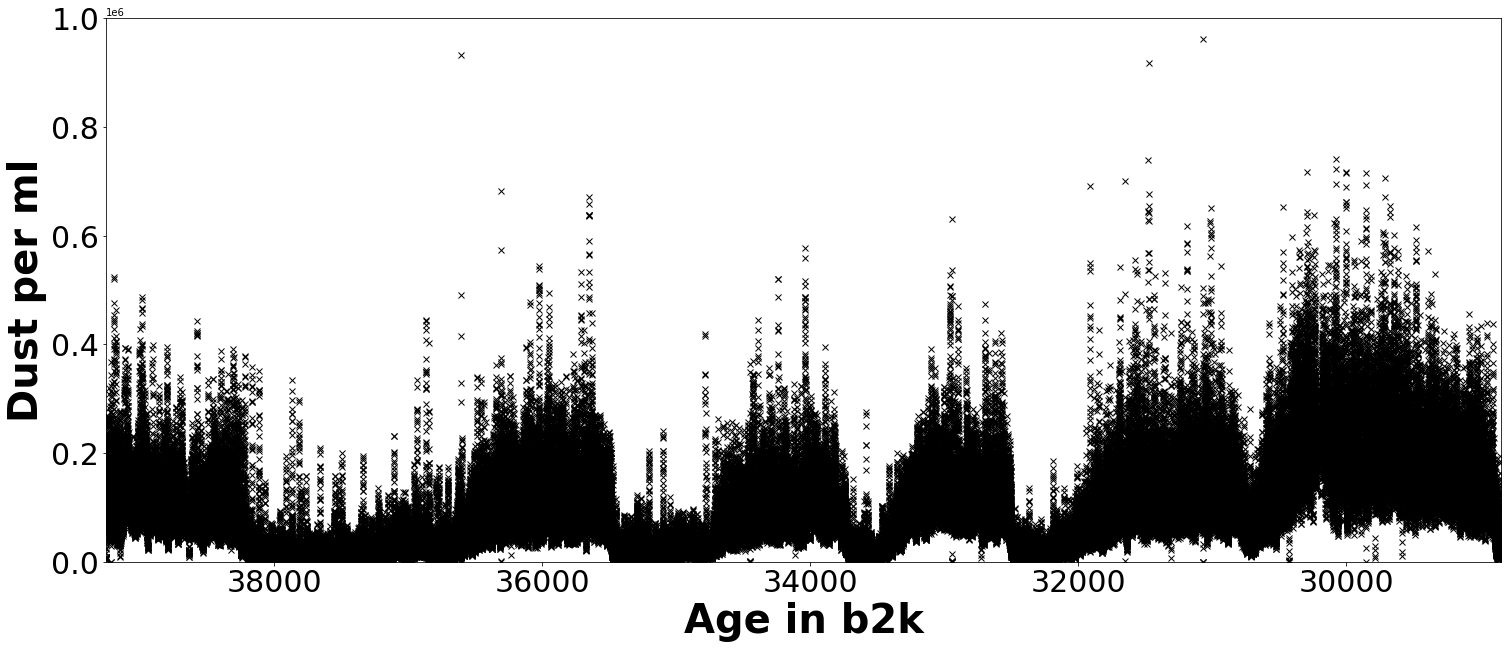

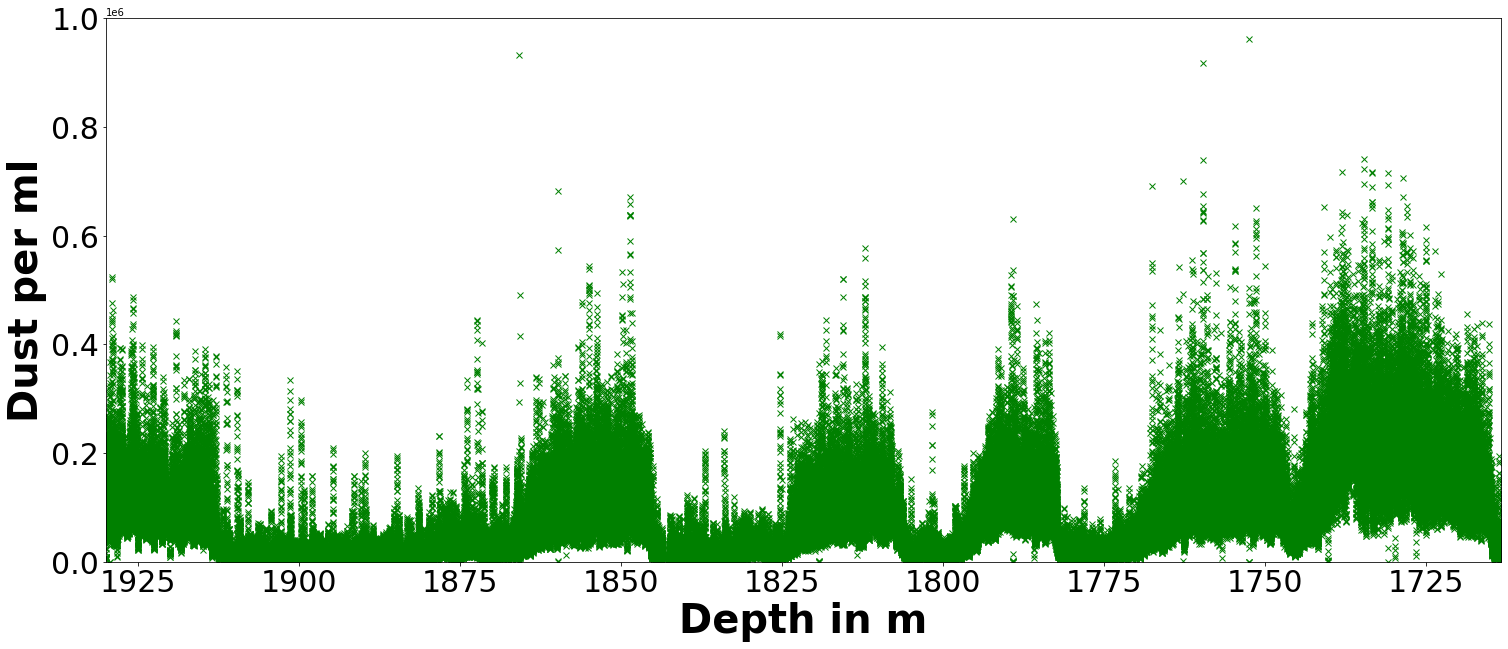

In [28]:
plt.figure(figsize = (25, 10))
plt.plot(Age_long_array, Dust_long_array, 'kx')
plt.axis([max(Age_long_array), min(Age_long_array), min(Dust_long_array), max(Dust_long_array)])
plt.ylim([0, 1000000])
plt.xlabel('Age in b2k', fontsize=40, fontweight = 'bold')
plt.ylabel('Dust per ml', fontsize=40, fontweight = 'bold')
plt.xticks(size = 30)
plt.yticks(size = 30)

plt.figure(figsize = (25, 10))
plt.plot(Depth_long_array, Dust_long_array, 'gx')
plt.axis([max(Depth_long_array), min(Depth_long_array), min(Dust_long_array), max(Dust_long_array)])
plt.ylim([0, 1000000])
plt.xlabel('Depth in m', fontsize=40, fontweight = 'bold')
plt.ylabel('Dust per ml', fontsize=40, fontweight = 'bold')
plt.xticks(size = 30)
plt.yticks(size = 30)

(array([28000., 30000., 32000., 34000., 36000., 38000., 40000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

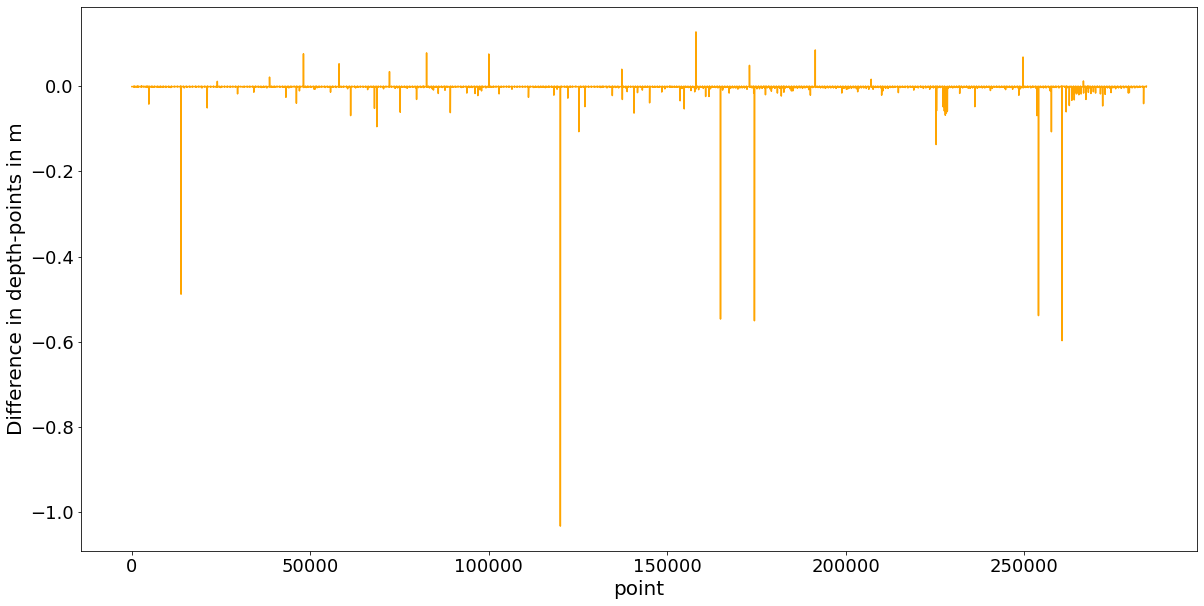

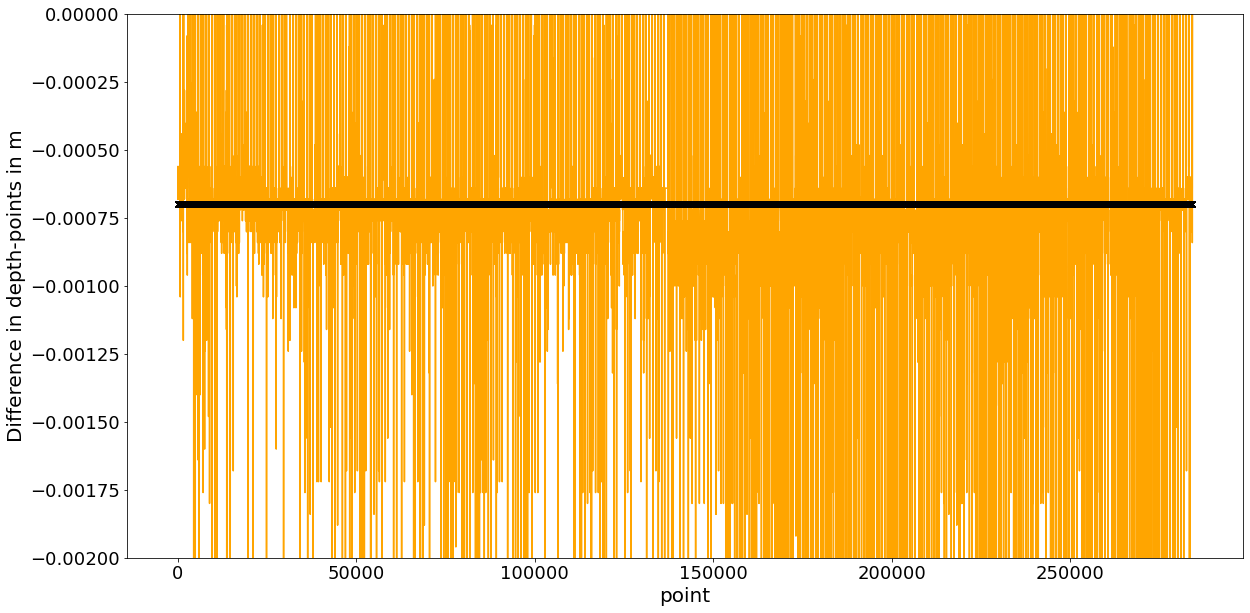

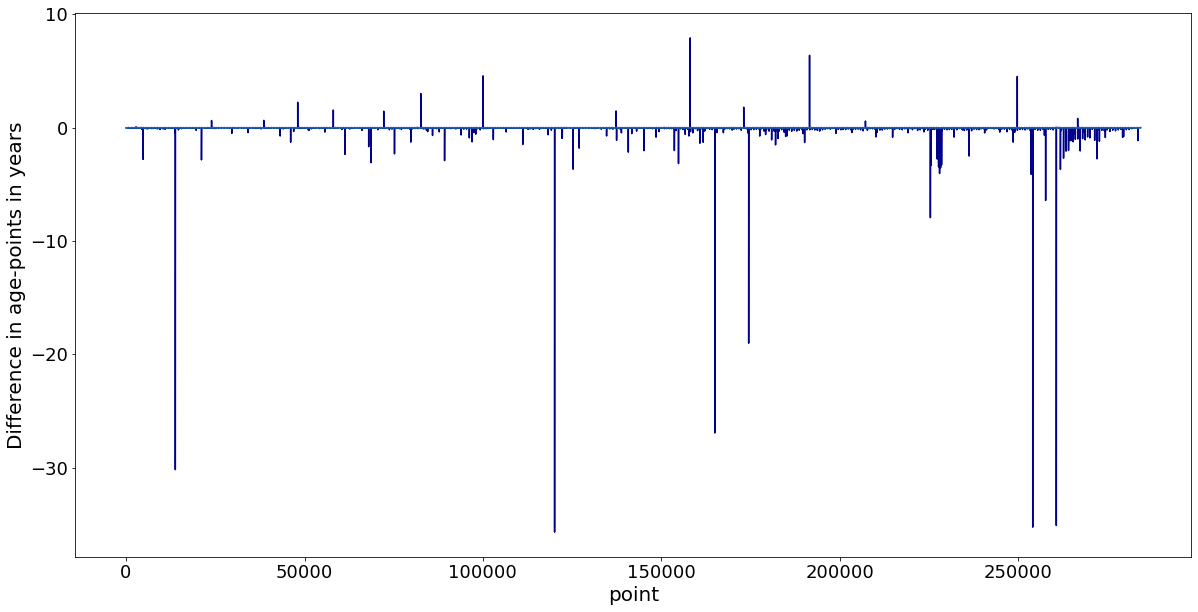

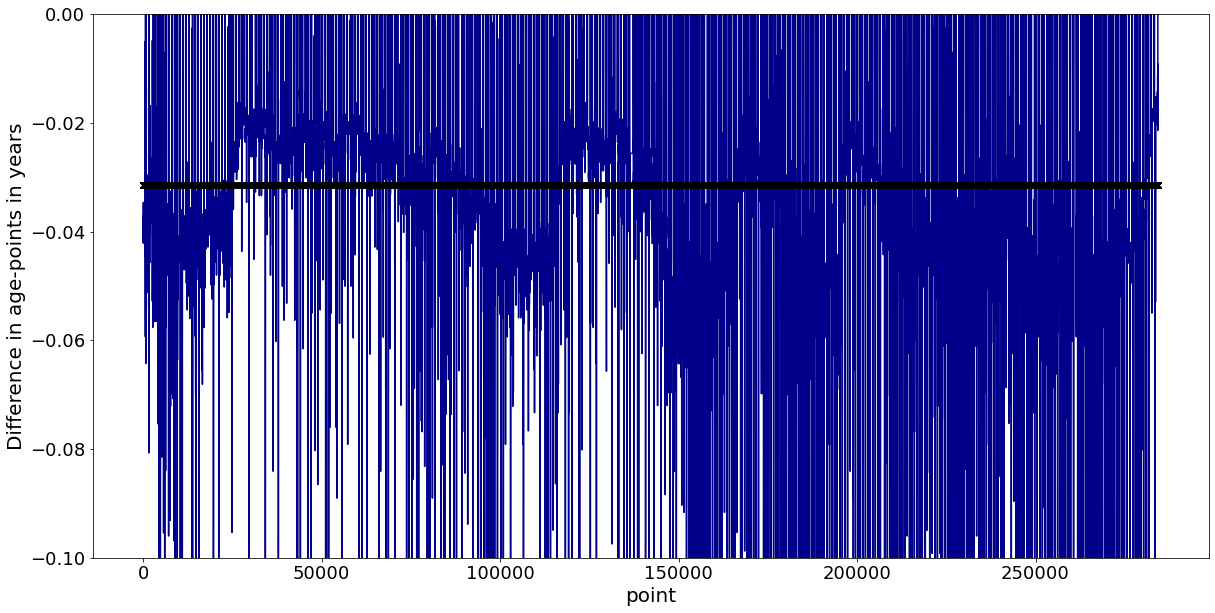

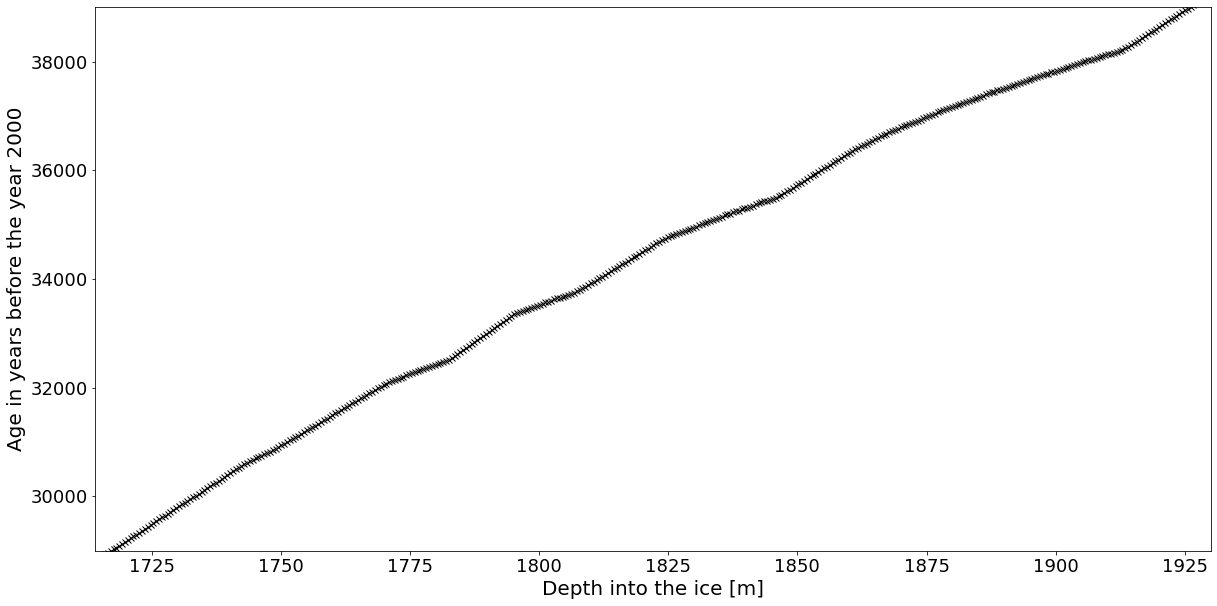

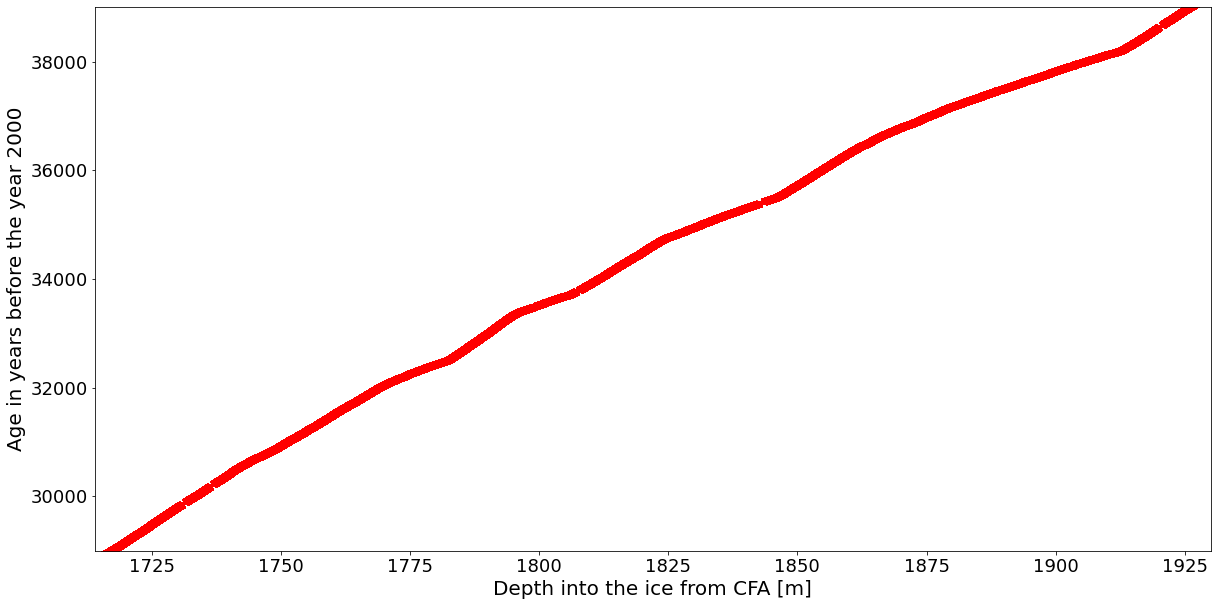

In [29]:
#Look more specifically into the resolution:
Differences_age_long_array = []
for i in range(len(Age_long_array) - 1):
    Differences_age_long_array.append(Age_long_array[i + 1] - Age_long_array[i])   

#Investigate Differences in Depth_long_array:
Differences_depth_long_array = []
for i in range(len(Depth_long_array) - 1):
    Differences_depth_long_array.append(Depth_long_array[i + 1] - Depth_long_array[i]) 

x = np.arange(0, len(Differences_depth_long_array), 1)
plt.figure(figsize = (20, 10))
plt.plot(x, Differences_depth_long_array, 'orange') 
plt.xlabel('point', fontsize = 20)
plt.ylabel('Difference in depth-points in m', fontsize = 20)
plt.xticks(size = 18)
plt.yticks(size = 18)

x = np.arange(0, len(Differences_depth_long_array), 1)
plt.figure(figsize = (20, 10))
plt.plot(x, Differences_depth_long_array, 'orange')
plt.plot(x, np.full(len(x), -0.0007), 'kx')
plt.ylim([-0.002, 0])
plt.xlabel('point', fontsize = 20)
plt.ylabel('Difference in depth-points in m', fontsize = 20)
plt.xticks(size = 18)
plt.yticks(size = 18)

x = np.arange(0, len(Differences_age_long_array), 1)
plt.figure(figsize = (20, 10))
plt.plot(x, Differences_age_long_array, 'darkblue')
plt.plot(x, np.full(len(x), -0.0315))
plt.xlabel('point', fontsize = 20)
plt.ylabel('Difference in age-points in years', fontsize = 20)
plt.xticks(size = 18)
plt.yticks(size = 18)

x = np.arange(0, len(Differences_age_long_array), 1)
plt.figure(figsize = (20, 10))
plt.plot(x, Differences_age_long_array, 'darkblue')
plt.plot(x, np.full(len(x), -0.0315), 'kx')
plt.ylim([-0.1, 0])
plt.xlabel('point', fontsize = 20)
plt.ylabel('Difference in age-points in years', fontsize = 20)
plt.xticks(size = 18)
plt.yticks(size = 18)

Data = np.loadtxt('GICC05-EGRIP-1_10Jun2021.txt')
Depth_ice = Data[:, 0]
Age = Data[:, 1]

plt.figure(figsize = (20, 10))
plt.plot(Depth_ice, Age, 'kx')
plt.xlabel('Depth into the ice [m]', fontsize = 20)
plt.ylabel('Age in years before the year 2000', fontsize = 20)
plt.xlim([1714,1930])
plt.ylim([29000, 39000])
plt.xticks(size = 18)
plt.yticks(size = 18)

plt.figure(figsize = (20, 10))
plt.plot(Depth_long_array, Age_long_array, 'rx')
plt.xlabel('Depth into the ice from CFA [m]', fontsize = 20)
plt.ylabel('Age in years before the year 2000', fontsize = 20)
plt.xlim([1714,1930])
plt.ylim([29000, 39000])
plt.xticks(size = 18)
plt.yticks(size = 18)


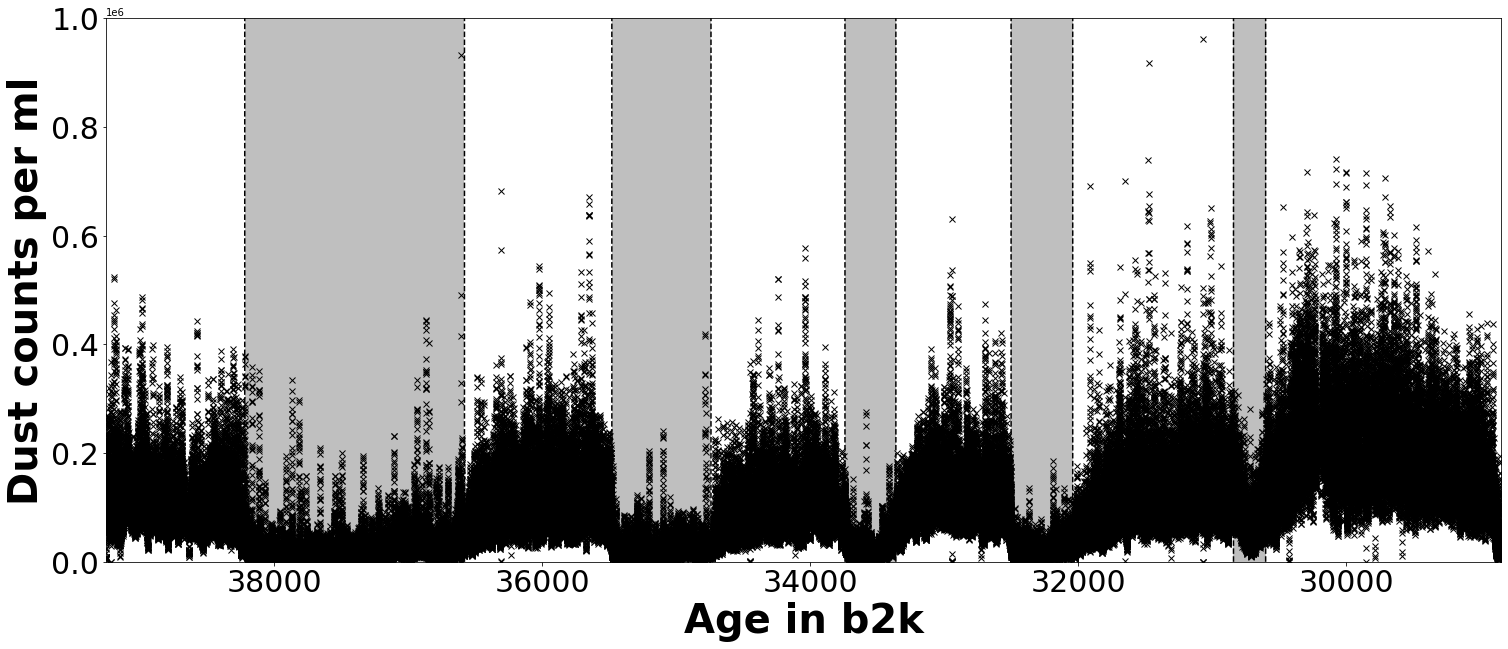

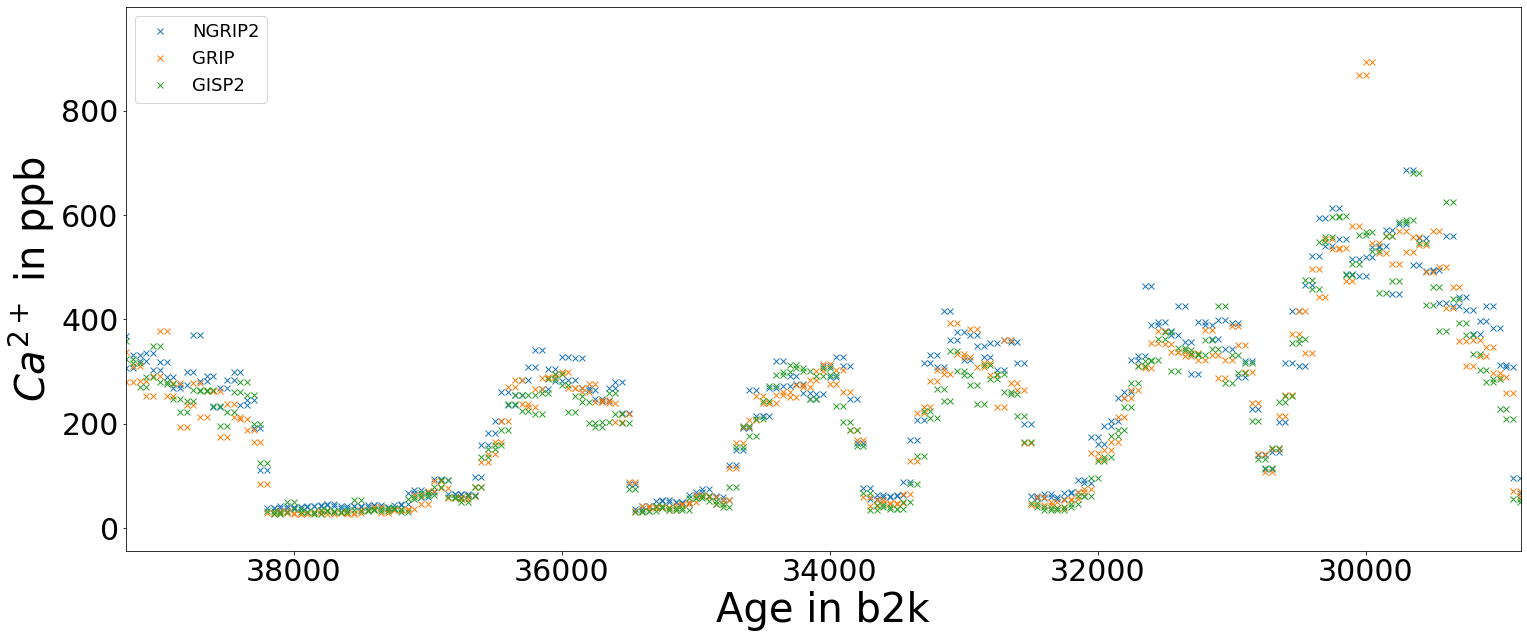

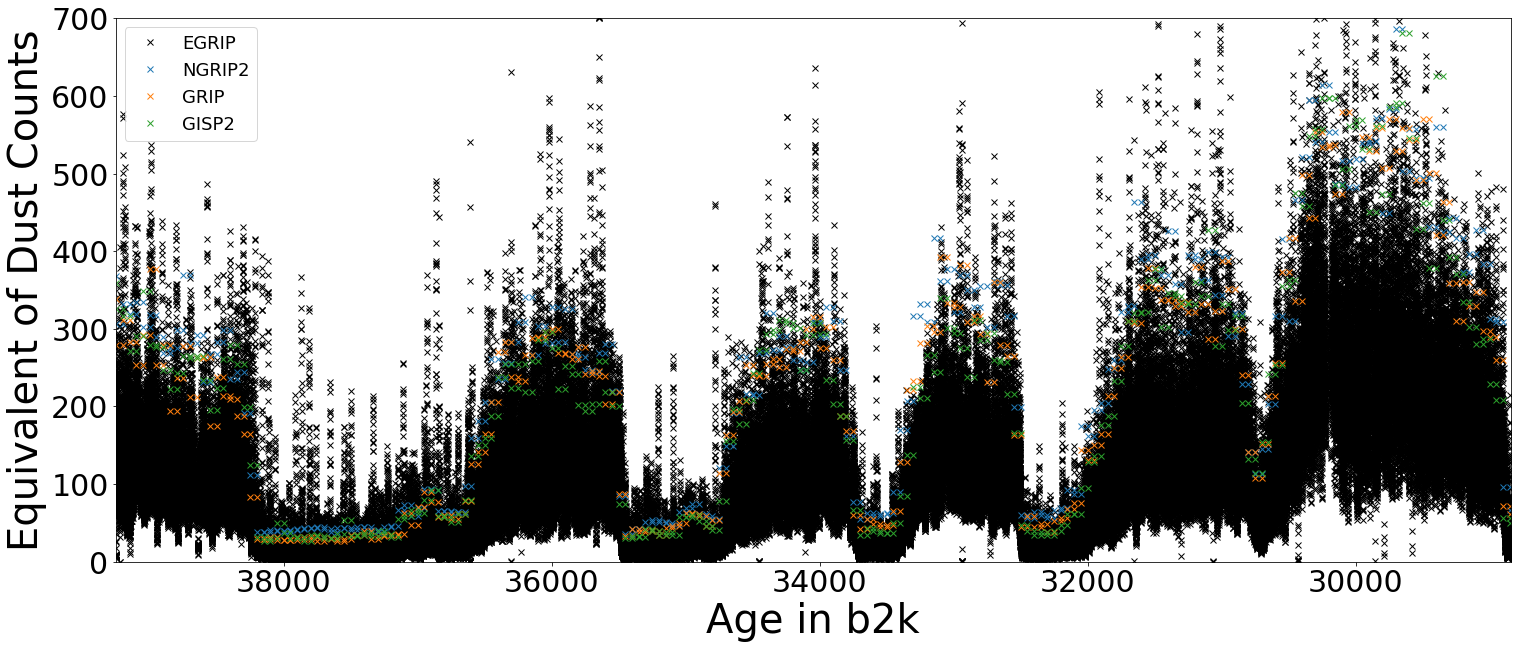

In [31]:
plt.figure(figsize = (25, 10))
plt.plot(Age_long_array, Dust_long_array, 'kx')
plt.axis([max(Age_long_array), min(Age_long_array), min(Dust_long_array), max(Dust_long_array)])
plt.ylim([0, 1000000])
plt.xlabel('Age in b2k', fontsize=40, fontweight = 'bold')
plt.ylabel('Dust counts per ml', fontsize=40, fontweight = 'bold')
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.plot(np.full(1000000, 38220), np.linspace(0, 1000000, 1000000), 'k--')
plt.plot(np.full(1000000, 36580), np.linspace(0, 1000000, 1000000), 'k--')
plt.plot(np.full(1000000, 35480), np.linspace(0, 1000000, 1000000), 'k--')
plt.plot(np.full(1000000, 34740), np.linspace(0, 1000000, 1000000), 'k--')
plt.plot(np.full(1000000, 33740), np.linspace(0, 1000000, 1000000), 'k--')
plt.plot(np.full(1000000, 33360), np.linspace(0, 1000000, 1000000), 'k--')
plt.plot(np.full(1000000, 32500), np.linspace(0, 1000000, 1000000), 'k--')
plt.plot(np.full(1000000, 32040), np.linspace(0, 1000000, 1000000), 'k--')
plt.plot(np.full(1000000, 30840), np.linspace(0, 1000000, 1000000), 'k--')
plt.plot(np.full(1000000, 30600), np.linspace(0, 1000000, 1000000), 'k--')
Ages_of_transition = [Age_long_array[0], 38220, 36580, 35480, 34740, 33740, 33360, 32500, 32040, 30840, 30600, Age_long_array[-1]]
reverse_Age_of_transition = np.sort(Ages_of_transition)
for i in np.arange(1, len(Ages_of_transition) - 1, 2):
    plt.axvspan(Ages_of_transition[i], Ages_of_transition[i + 1], facecolor='grey', alpha=0.5)

Age = np.loadtxt('GICC05modelext_GRIP_and_GISP2_and_resampled_data_series_Seierstad_et_al._2014_version_10Dec2014-2.csv', skiprows = 13, delimiter = ';', usecols = 0)
Ca_NGRIP2 = np.loadtxt('GICC05modelext_GRIP_and_GISP2_and_resampled_data_series_Seierstad_et_al._2014_version_10Dec2014-2.csv', skiprows = 13, delimiter = ';', usecols = 1)
Ca_GRIP = np.loadtxt('GICC05modelext_GRIP_and_GISP2_and_resampled_data_series_Seierstad_et_al._2014_version_10Dec2014-2.csv', skiprows = 13, delimiter = ';', usecols = 2)
Ca_GISP2 = np.loadtxt('GICC05modelext_GRIP_and_GISP2_and_resampled_data_series_Seierstad_et_al._2014_version_10Dec2014-2.csv', skiprows = 13, delimiter = ';', usecols = 3)

plt.figure(figsize = (25, 10))
plt.plot(Age, Ca_NGRIP2, 'x', label = 'NGRIP2')
plt.plot(Age, Ca_GRIP, 'x', label = 'GRIP')
plt.plot(Age, Ca_GISP2, 'x', label = 'GISP2')
plt.xlim([39255, 28842.8])
plt.xlabel('Age in b2k', fontsize = 40)
plt.ylabel(r'$Ca^{2+}$ in ppb', fontsize = 40)
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.legend(fontsize = 18, loc = 'upper left')

plt.figure(figsize = (25,10))
plt.plot(Age_long_array, Dust_long_array * 0.0011, 'kx', label = 'EGRIP')
plt.plot(Age, Ca_NGRIP2, 'x', label = 'NGRIP2')
plt.plot(Age, Ca_GRIP, 'x', label = 'GRIP')
plt.plot(Age, Ca_GISP2, 'x', label = 'GISP2')
plt.ylim([0, 700])
plt.xlim([39255, 28842.8])
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.xlabel('Age in b2k', size = 40)
plt.ylabel('Equivalent of Dust Counts', size = 40)
plt.legend(fontsize = 18, loc = 'upper left')

